In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=5000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_2D import data_generator
# from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator
from Model_2D_RCAN import make_generator

from loss_2D import generator_loss
from skimage import exposure
from skimage.exposure import match_histograms
from skimage.exposure import histogram

1 Physical GPUs, 1 Logical GPUs


In [2]:
patch_size = 256
n_patches =  8
n_channel =  0
augment = False
shuffle = True 
batch_size = 1
add_noise=False
lp = 0.1

GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\train\Average.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\train\1frame.tif'

x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold = 0,ratio=1.0,lp=lp, augment=augment, shuffle=shuffle,
                                                   add_noise=add_noise)

(13, 1, 2048, 2048)
832
The training set shape is: (832, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


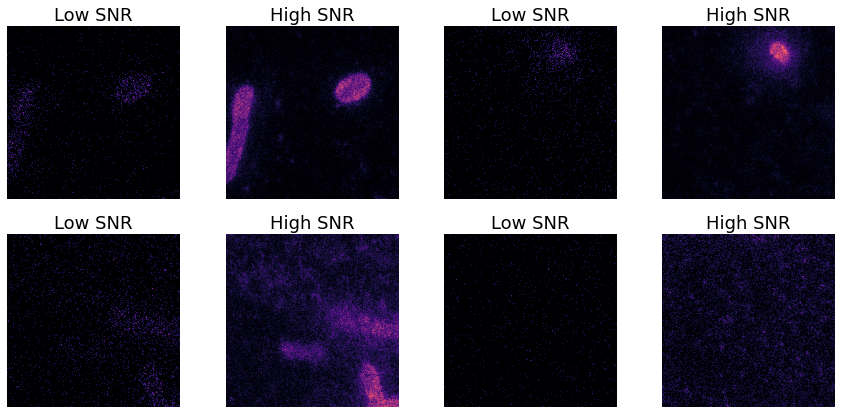

In [3]:
ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    norm_x = np.linalg.norm(x_train[ix[i]], axis=(0, 1))
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [4]:
model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\mitochondria_rcan.h5" 
load_model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\histon_2step.h5" 


n_epochs =  400
gen_lr = 1e-4

filters =[64,128,256]
# filters =[80,160,320,640]
num_filters = filters[0]
filters_cab=num_filters/8
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss='mse')
# generator.load_weights(load_model_save_directory)



# lr_max = 1e-4
# lr_min = 1e-6
# T = 40
# a1 = 0.7
# a2 = 0.7
# def scheduler(epoch, lr):
#     lr_min_i = a1**np.floor((epoch)/T)*lr_min
#     lr_max_i = a2**np.floor((epoch)/T)*lr_max
#     lr = lr_min_i+0.5*(lr_max_i-lr_min_i)*(1+np.cos(np.pi*np.mod(epoch,T)/(T-1)))
#     return lr

# def scheduler(epoch, lr):
#     lr = 1e-9*10**(epoch/20)
#     return lr

lr_max = 1e-4
lr_min = 1e-6
a1 = 0.5
T = 20
def scheduler(epoch, lr):
    if lr>lr_min:
        lr = gen_lr*(a1**np.floor((epoch+1)/T))
    else:
        lr = lr_min
    return lr

# callbacks = [
#     LearningRateScheduler(scheduler),
#     ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

callbacks = [
    EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [LearningRateScheduler(scheduler)]


In [5]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/400
748/748 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00001: val_loss improved from inf to 0.00679, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\mitochondria_rcan.h5
748/748 [==============================] - 145s 188ms/step - loss: 0.0085 - val_loss: 0.0068 - lr: 1.0000e-04
Epoch 2/400
748/748 [==============================] - ETA: 0s - loss: 0.0073
Epoch 00002: val_loss did not improve from 0.00679
748/748 [==============================] - 138s 185ms/step - loss: 0.0073 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 3/400
748/748 [==============================] - ETA: 0s - loss: 0.0072
Epoch 00003: val_loss improved from 0.00679 to 0.00653, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\mitochondria_rcan.h5
748/748 [==============================] - 139s 185ms/step - loss: 0.0072 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 4/400
748/748 [========

Epoch 30/400
748/748 [==============================] - ETA: 0s - loss: 0.0064
Epoch 00030: val_loss improved from 0.00628 to 0.00610, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\mitochondria_rcan.h5
748/748 [==============================] - 139s 185ms/step - loss: 0.0064 - val_loss: 0.0061 - lr: 5.0000e-05
Epoch 31/400
748/748 [==============================] - ETA: 0s - loss: 0.0063
Epoch 00031: val_loss did not improve from 0.00610
748/748 [==============================] - 138s 185ms/step - loss: 0.0063 - val_loss: 0.0063 - lr: 5.0000e-05
Epoch 32/400
748/748 [==============================] - ETA: 0s - loss: 0.0063
Epoch 00032: val_loss did not improve from 0.00610
748/748 [==============================] - 139s 185ms/step - loss: 0.0063 - val_loss: 0.0064 - lr: 5.0000e-05
Epoch 33/400
748/748 [==============================] - ETA: 0s - loss: 0.0064
Epoch 00033: val_loss did not improve from 0.00610
748/748 [============

Epoch 60/400
748/748 [==============================] - ETA: 0s - loss: 0.0061
Epoch 00060: val_loss improved from 0.00594 to 0.00593, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\mitochondria_rcan.h5
748/748 [==============================] - 139s 186ms/step - loss: 0.0061 - val_loss: 0.0059 - lr: 1.2500e-05
Epoch 61/400
748/748 [==============================] - ETA: 0s - loss: 0.0061
Epoch 00061: val_loss did not improve from 0.00593
748/748 [==============================] - 139s 185ms/step - loss: 0.0061 - val_loss: 0.0060 - lr: 1.2500e-05
Epoch 62/400
748/748 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00062: val_loss did not improve from 0.00593
748/748 [==============================] - 139s 185ms/step - loss: 0.0060 - val_loss: 0.0059 - lr: 6.2500e-06
Epoch 63/400
748/748 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00063: val_loss improved from 0.00593 to 0.00591, saving model to 

Epoch 91/400
748/748 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00091: val_loss did not improve from 0.00590
748/748 [==============================] - 140s 188ms/step - loss: 0.0060 - val_loss: 0.0059 - lr: 1.5625e-06
Epoch 92/400
748/748 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00092: val_loss did not improve from 0.00590
748/748 [==============================] - 140s 188ms/step - loss: 0.0060 - val_loss: 0.0059 - lr: 7.8125e-07
Epoch 93/400
748/748 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00093: val_loss did not improve from 0.00590
748/748 [==============================] - 141s 188ms/step - loss: 0.0060 - val_loss: 0.0059 - lr: 7.8125e-07
Epoch 94/400
748/748 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00094: val_loss did not improve from 0.00590
748/748 [==============================] - 141s 188ms/step - loss: 0.0060 - val_loss: 0.0059 - lr: 7.8125e-07
Epoch 95/400
748/748 [==================